# Time Series Season Classification Based on Energy Consumption

## Imports

In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sktime
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.transformations.panel.rocket import MiniRocket
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)
warnings.simplefilter('ignore')

## Data

---------
The data  includes hourly time series data from the EU and neighboring countries (about power system modelling,  electricity prices, electricity consumption (load) as well as wind and solar power generation and capacities)
This data is sourced from the ENTSO-E Transparency platform, covering years from 2015 to mid-2020.
Data includes variables such as electricity consumption, generation capacity, and prices.


In [3]:
df_raw = pd.read_csv('time_series_60min_singleindex.csv', index_col='utc_timestamp', parse_dates=True, low_memory=False)
df_raw.head()

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,734.81,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,766.64,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,733.13,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN


In [4]:
df_raw.columns

Index(['cet_cest_timestamp', 'AT_load_actual_entsoe_transparency',
       'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead',
       'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual',
       'BE_load_actual_entsoe_transparency',
       'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual',
       'BE_wind_generation_actual',
       ...
       'SI_load_actual_entsoe_transparency',
       'SI_load_forecast_entsoe_transparency', 'SI_solar_generation_actual',
       'SI_wind_onshore_generation_actual',
       'SK_load_actual_entsoe_transparency',
       'SK_load_forecast_entsoe_transparency', 'SK_solar_generation_actual',
       'SK_wind_onshore_generation_actual',
       'UA_load_actual_entsoe_transparency',
       'UA_load_forecast_entsoe_transparency'],
      dtype='object', length=299)

## Data preprocessing

In [5]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    
    ###3  remove country codes from   labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    
    #### Exclude IF OUSTIDE OF RANGE
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
        
    return df_out


def transform_dataframe(df, cols_map):
    
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # MWt to GWt
    df = df / 1000
    df = df.resample('D').sum(min_count=24) # 24 DATA BY THE HOUR SO WE WANT TO CHANGE IT TO DAYS
    df = df.rename_axis('Date')
    df.index = df.index.strftime('%Y-%m-%d')
    return df

## Extracting and Preprocessing UK Data from 2015 to 2019

In [6]:
df_uk = extract_country(df_raw, country_code='GB', year_min=2015, year_max=2019)
df_uk

,GBN_load_actual_entsoe_transparency,GBN_load_forecast_entsoe_transparency,GBN_price_day_ahead,GBN_solar_capacity,GBN_solar_generation_actual,GBN_solar_profile,GBN_wind_capacity,GBN_wind_generation_actual,GBN_wind_profile,GBN_wind_offshore_capacity,...,UKM_load_actual_entsoe_transparency,UKM_load_forecast_entsoe_transparency,UKM_solar_capacity,UKM_solar_generation_actual,UKM_wind_capacity,UKM_wind_generation_actual,UKM_wind_offshore_capacity,UKM_wind_offshore_generation_actual,UKM_wind_onshore_capacity,UKM_wind_onshore_generation_actual
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,26758.0,32057.0,NaN,2669.0,NaN,NaN,11555.0,NaN,NaN,4040.0,...,27607.0,NaN,2669.0,NaN,12214.0,NaN,4040.0,NaN,8174.0,385.0
2015-01-01 01:00:00+00:00,27166.0,31738.0,NaN,2669.0,NaN,NaN,11555.0,782.0,0.0676,4040.0,...,27948.0,NaN,2669.0,NaN,12214.0,1148.0,4040.0,117.0,8174.0,1041.0
2015-01-01 02:00:00+00:00,24472.0,30690.0,NaN,2669.0,NaN,NaN,11555.0,785.0,0.0680,4040.0,...,25210.0,NaN,2669.0,NaN,12214.0,1139.0,4040.0,120.0,8174.0,1020.0
2015-01-01 03:00:00+00:00,23003.0,28442.0,NaN,2669.0,NaN,NaN,11555.0,776.0,0.0672,4040.0,...,23693.0,NaN,2669.0,NaN,12214.0,1053.0,4040.0,115.0,8174.0,938.0
2015-01-01 04:00:00+00:00,21832.0,25978.0,NaN,2669.0,NaN,NaN,11555.0,773.0,0.0669,4040.0,...,22476.0,NaN,2669.0,NaN,12214.0,1048.0,4040.0,114.0,8174.0,934.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,39898.0,35036.0,39.07,NaN,0.0,NaN,NaN,4823.0,NaN,NaN,...,41166.0,36074.0,NaN,0.0,NaN,4966.0,NaN,1843.0,NaN,3122.0
2019-12-31 20:00:00+00:00,37223.0,32512.0,37.71,NaN,0.0,NaN,NaN,5052.0,NaN,NaN,...,38376.0,33518.0,NaN,0.0,NaN,5229.0,NaN,1961.0,NaN,3269.0
2019-12-31 21:00:00+00:00,34536.0,30693.0,34.22,NaN,0.0,NaN,NaN,5139.0,NaN,NaN,...,35579.0,31662.0,NaN,0.0,NaN,5399.0,NaN,1793.0,NaN,3606.0


##### Hourly to Daily (24 hours)

In [7]:
cols_map = {'GBN_load_actual_entsoe_transparency' : 'Consumption',
            'GBN_wind_generation_actual' : 'Wind',
            'GBN_solar_generation_actual' : 'Solar'}

## applying transformation
df_uk = transform_dataframe(df_uk, cols_map)
df_uk.shape

(1826, 3)

In [8]:
#CREATE A COMBINATION OF WIND AND SOLAR
df_uk['Wind+Solar'] = df_uk[['Wind', 'Solar']].sum(axis=1, skipna=False)
df_uk.to_csv('UK.csv')
df_uk.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01,679.307,NaN,NaN,NaN
2015-01-02,740.544,19.998,3.834,23.832
2015-01-03,744.237,8.487,1.026,9.513
2015-01-04,742.192,5.860,2.711,8.571
2015-01-05,997.524,82.669,2.035,84.704


The cleaned DataFrame **df_uk** consists of daily electricity usage data for the UK. It includes the following time series arranged as columns:
*******
- **Date:** Date represented 
- **Consumption:** Total electricity consumption measured in gigawatt-hours (GWh).
- **Wind:** Consumption of wind energy in gigawatts per hour (GW/h).
- **Solar:** Consumption of solar energy in gigawatts per hour (GW/h).
- **Wind+Solar:** Combined consumption from wind and solar energy sources in gigawatts per hour (GW/h).

## Explore Data

In [9]:
df = pd.read_csv('UK.csv', parse_dates=['Date'], index_col="Date")
df.sample(5)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2019-03-09,818.796,210.952,30.602,241.554
2018-09-07,750.092,135.808,42.825,178.633
2019-01-03,939.332,39.062,4.204,43.266
2019-02-06,972.514,105.963,14.046,120.009
2017-01-25,956.757,141.793,14.503,156.296


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  1824 non-null   float64
 1   Wind         1816 non-null   float64
 2   Solar        1816 non-null   float64
 3   Wind+Solar   1816 non-null   float64
dtypes: float64(4)
memory usage: 71.3 KB


In [11]:
df.shape

(1826, 4)

In [12]:
df.describe()

,Consumption,Wind,Solar,Wind+Solar
count,1824.000000,1816.000000,1816.000000,1816.000000
mean,852.570230,103.605937,27.108445,130.714382
std,100.415716,56.195037,18.107707,52.707597
min,476.203000,5.088000,0.690000,8.571000
25%,777.801750,57.585500,11.387000,89.521750
50%,844.912000,96.094500,24.708500,125.622000
75%,925.793250,144.365750,40.193500,166.878000
max,1121.540000,280.527000,77.744000,296.640000


## Data cleaning

In [13]:
df.isna().sum()

Consumption     2
Wind           10
Solar          10
Wind+Solar     10
dtype: int64

In [14]:
df.fillna(method='ffill', axis=0, inplace=True)

# Time Series  Classification

- Divide the dataset into four seasons: winter, spring, autumn, and summer.
- Each data point is the consumption recorded in 1-hour intervals.therefore:
  - Define sections of 24 hours (1 day).
  - Each part makes up 24 data points representing hourly consumption.

In [15]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
    return df_out

def transform_dataframe(df, cols_map):
    df = df[list(cols_map.keys())].rename(columns=cols_map)    
    df = df / 1000 #### Convert from MW to GW
    df = df.rename_axis('Date')
    return df

def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

## Data

In [16]:
df_all = pd.read_csv('time_series_60min_singleindex.csv', index_col='utc_timestamp', parse_dates=True, low_memory=False)

df_hrly = extract_country(df_all, country_code='GB', year_min=2015, year_max=2019)

df_hrly.sample(3)

cols_map = {'GBN_load_actual_entsoe_transparency' : 'Consumption',
            'GBN_wind_generation_actual' : 'Wind',
            'GBN_solar_generation_actual' : 'Solar'}
df = transform_dataframe(df_hrly, cols_map).dropna()

df['Wind+Solar'] = df[['Wind', 'Solar']].sum(axis=1, skipna=False)
df.to_csv('be_clf_data2.csv')
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01 09:00:00+00:00,25.206,0.836,0.013,0.849
2015-01-01 10:00:00+00:00,27.222,0.879,0.063,0.942
2015-01-01 11:00:00+00:00,29.048,0.899,0.054,0.953
2015-01-01 12:00:00+00:00,31.222,0.958,0.046,1.004
2015-01-01 13:00:00+00:00,32.189,0.989,0.037,1.026


### Splitting into seasons

In [17]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(450, 24) (458, 24) (453, 24) (458, 24)


### Seasons visualization

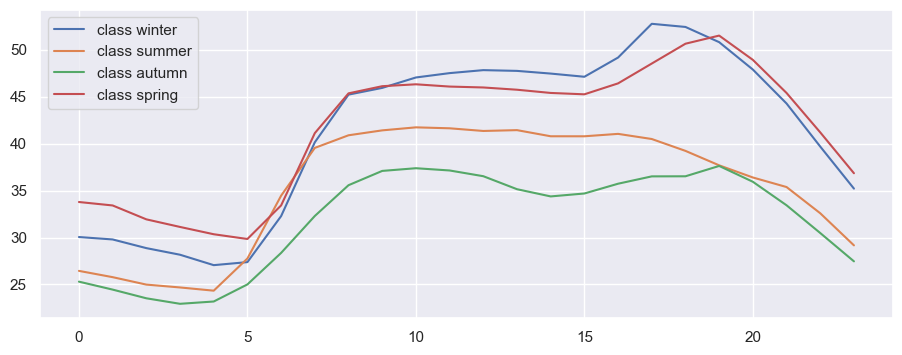

In [18]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

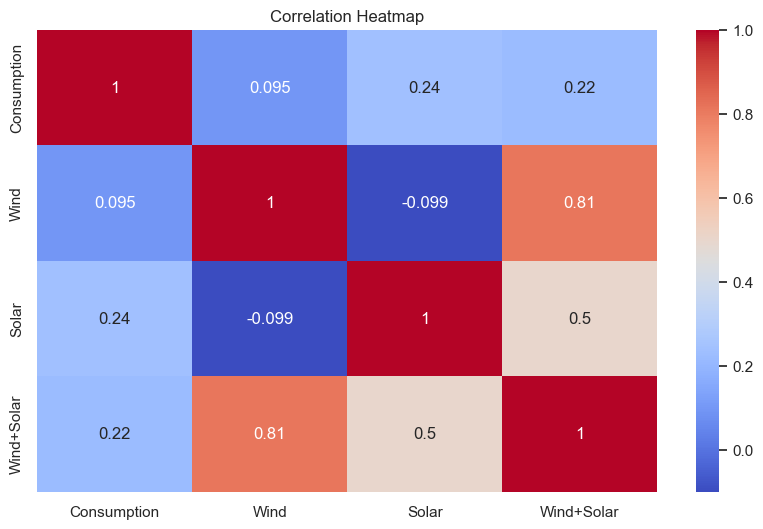

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


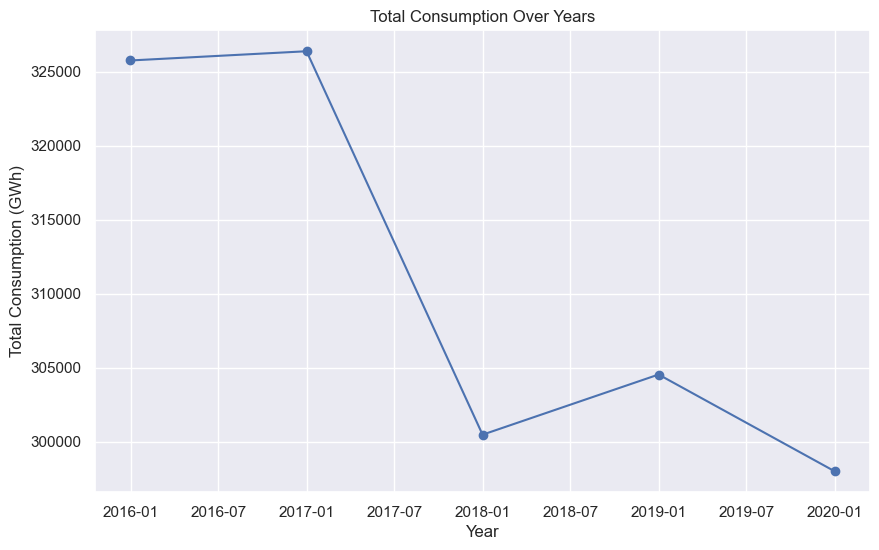

In [20]:
df_yearly = df.resample('Y').sum()
plt.figure(figsize=(10, 6))
plt.plot(df_yearly.index, df_yearly['Consumption'], marker='o')
plt.title('Total Consumption Over Years')
plt.xlabel('Year')
plt.ylabel('Total Consumption (GWh)')
plt.grid(True)
plt.show()


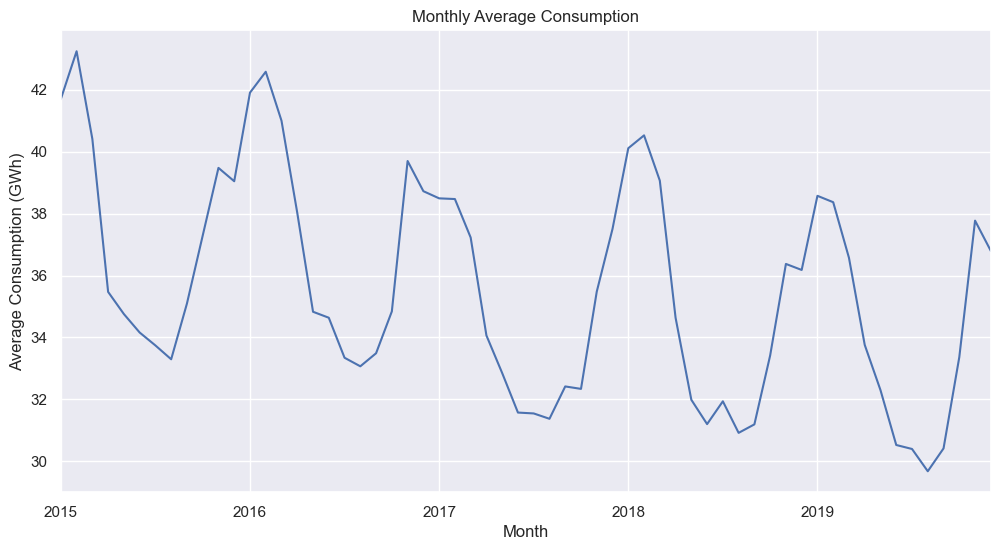

In [21]:
df_monthly = df.resample('M').mean()
plt.figure(figsize=(12, 6))
df_monthly['Consumption'].plot()
plt.title('Monthly Average Consumption')
plt.xlabel('Month')
plt.ylabel('Average Consumption (GWh)')
plt.grid(True)
plt.show()

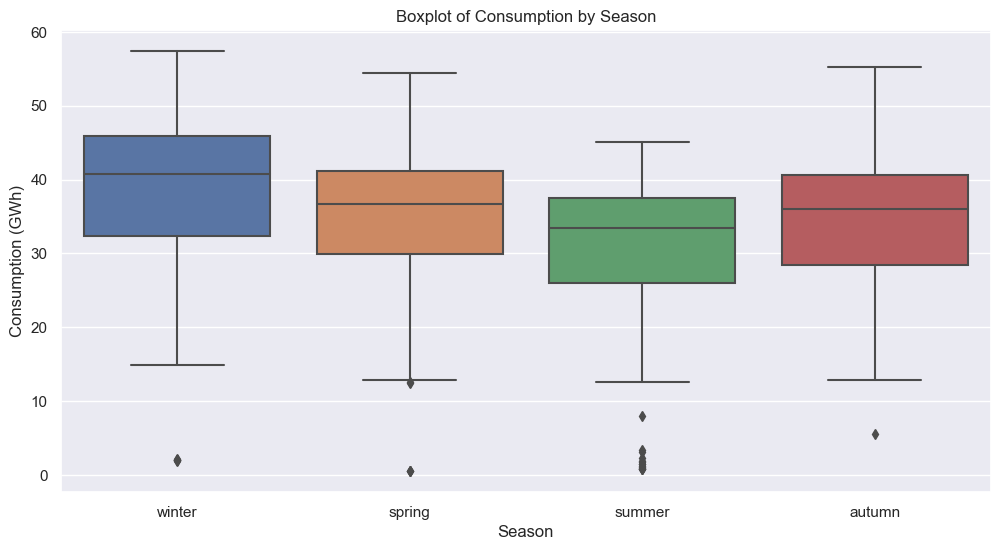

In [22]:

df['month'] = df.index.month
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}

# Assign season to each row
df['season'] = df['month'].apply(lambda x: 'winter' if x in seasons['winter'] else 
                                  'spring' if x in seasons['spring'] else 
                                  'summer' if x in seasons['summer'] else 
                                  'autumn')

plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='Consumption', data=df)
plt.title('Boxplot of Consumption by Season')
plt.xlabel('Season')
plt.ylabel('Consumption (GWh)')
plt.show()


## Preprocessing

In [23]:

X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1273, 24) (1273,) (546, 24) (546,)


In [24]:
result_table_clf = []

## RandomForestClassifier


In [25]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

result_table_clf.append([clf, round(clf.score(X_test, y_test), 3)])

 test score 0.958


## KNeighborsClassifier



In [26]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}') 

result_table_clf.append([clf, round(clf.score(X_test, y_test), 3)])

 test score 0.980


## MUSE (MUltivariate Symbolic Extension)



In [27]:
from sktime.classification.dictionary_based import MUSE    
clf = MUSE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

print(f' test score {clf.score(X_test, y_test):.3f}')

result_table_clf.append([clf, round(clf.score(X_test, y_test), 3)])

 test score 0.980


## Methods comparison

In [28]:
for item in result_table_clf:
    model_name = item[0].__class__.__name__
    model_value = item[1]
    print(f'{model_name}: {model_value}')

RandomForestClassifier: 0.958
KNeighborsClassifier: 0.98
MUSE: 0.98


# Deep Learning Models

In [29]:
from tsai.all import *
import warnings
computer_setup()

os              : macOS-14.4.1-arm64-arm-64bit
python          : 3.10.9
tsai            : 0.3.9
fastai          : 2.7.15
fastcore        : 1.5.29
torch           : 2.1.0
device          : mps
cpu cores       : 8
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A


## Data

In [30]:
X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    1*np.ones(winter.shape[0]),
                    2*np.ones(summer.shape[0]),
                    3*np.ones(autumn.shape[0]),
                    4*np.ones(spring.shape[0])
                   ))


X = np.atleast_3d(X).transpose(0,2,1)
y.astype(int)

array([1, 1, 1, ..., 4, 4, 4])

In [31]:

class_map = {
    1:'winter',   
    2:'summer',   
    3:'autumn',   
    4:'spring',   
    }
class_map

labeler = ReLabeler(class_map)
y = labeler(y) 

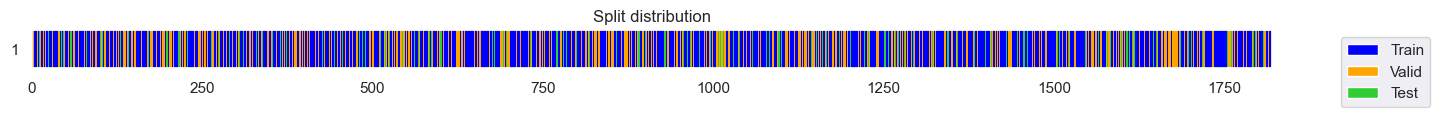

((#1093) [849,1085,1304,540,602,475,28,1276,657,1558...],
 (#545) [478,303,1260,238,1674,89,1222,1193,1190,510...],
 (#181) [692,310,769,647,80,675,453,599,929,1407...])

In [32]:
## split inot train, test and validation 
splits = get_splits(y, 
                    n_splits=1, 
                    valid_size=0.3, 
                    test_size=0.1, 
                    shuffle=True, 
                    balance=False, 
                    stratify=True,
                    random_state=42, 
                    show_plot=True, 
                    verbose=True)
splits

In [33]:
###dataset and loaders

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
 
bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

## ResNet 
Try pretrained Resnet and choose optimal learning rate to try find better accuracy

In [34]:
arch = ResNet
k = {}
model = create_model(arch, dls=dls, **k)
model = build_ts_model(ResNet, arch_config=k, dls=dls)

### Optimal learning rate

SuggestedLRs(valley=0.002511886414140463)

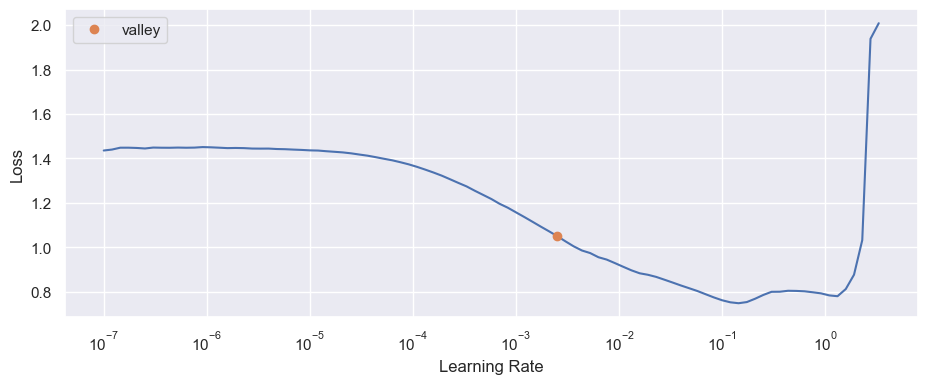

In [35]:
learn = ts_learner(dls, arch=model, metrics=accuracy) 
learn.lr_find()

In [36]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 200, lr_max = 0.0017)

epoch,train_loss,valid_loss,accuracy,time
0,1.355669,2.110014,0.249541,00:00
1,1.250998,1.575111,0.249541,00:00
2,1.163742,1.397377,0.255046,00:00
3,1.090195,1.280244,0.339450,00:00
4,1.025251,1.145007,0.517431,00:00
5,0.965080,0.985386,0.688073,00:00
6,0.907786,0.826940,0.777982,00:00
7,0.854483,0.693505,0.840367,00:00
8,0.805147,0.585783,0.847706,00:00
9,0.757537,0.494663,0.849541,00:00


## Confusion matrix

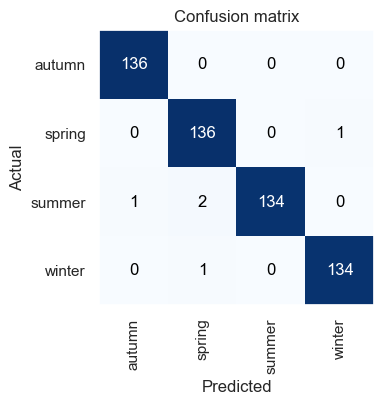

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [38]:
interp.most_confused(min_val=3)

[]

In [39]:
probas, _, preds = learn.get_X_preds(X[splits[2]])

class_map = {
    'winter':3,   
    'summer':2,   
    'autumn':0,   
    'spring':1,  
    }
class_map

labeler = ReLabeler(class_map)
labeler

<function tsai.data.preprocessing.ReLabeler.<locals>._relabel(y)>

In [40]:
model_score = accuracy_score(np.argmax(probas,axis=-1), labeler(y[splits[2]]))
print(f' test score {model_score}')
result_table_clf.append([model, round(model_score, 3)])

 test score 0.994475138121547


## LSTM and RNN Models 

In [41]:
import tensorflow as tf


In [42]:
def train_model(model, train_dl, valid_dl, epochs=50, batch_size=256):
    X_train, y_train = [], []
    for x, y in train_dl:
        X_train.append(x.cpu().numpy())  
        y_train.append(y.cpu().numpy())  
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    X_valid, y_valid = [], []
    for x, y in valid_dl:
        X_valid.append(x.cpu().numpy())  
        y_valid.append(y.cpu().numpy()) 
    X_valid = np.concatenate(X_valid)
    y_valid = np.concatenate(y_valid)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    return history


In [43]:
input_shape = X.shape[-2:]

model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=4, activation='softmax')  
])

model_LSTM.summary()


2024-06-02 16:23:11.517069: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-02 16:23:11.517130: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-02 16:23:11.517134: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-02 16:23:11.517156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 16:23:11.517175: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,020 (1.30 MB)

 Trainable params: 342,020 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_LSTM = train_model(model_LSTM, dls.train, dls.valid, epochs=50)


Epoch 1/50


2024-06-02 16:23:12.158470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.2796 - loss: 1.3827 - val_accuracy: 0.4697 - val_loss: 1.2843
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4280 - loss: 1.2801 - val_accuracy: 0.6110 - val_loss: 1.0550
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5376 - loss: 1.0873 - val_accuracy: 0.7211 - val_loss: 0.8390
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6096 - loss: 0.9607 - val_accuracy: 0.7321 - val_loss: 0.7716
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6154 - loss: 0.9184 - val_accuracy: 0.8165 - val_loss: 0.6292
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7005 - loss: 0.7712 - val_accuracy: 0.8018 - val_loss: 0.6098
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7236 - loss: 0.7759 - val_accuracy: 0.8147 - val_loss: 0.5544
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7574 - loss: 0.7076 - val_accuracy: 0.8404 - val_loss: 0.4895
Epoch 9/50

In [45]:

for X_valid, y_valid in dls.valid:
    break   

X_valid_cpu = X_valid.cpu()

probas_lstm = model_LSTM.predict(X_valid_cpu)
preds_lstm = np.argmax(probas_lstm, axis=-1)



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [46]:
from sklearn.metrics import classification_report

print("Classification Report for LSTM model:")
print(classification_report(y_valid.cpu().numpy(), preds_lstm))


Classification Report for LSTM model:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       126
           1       0.96      0.92      0.94       132
           2       0.88      0.95      0.91       129
           3       0.93      0.98      0.95       125

    accuracy                           0.94       512
   macro avg       0.94      0.94      0.94       512
weighted avg       0.94      0.94      0.94       512



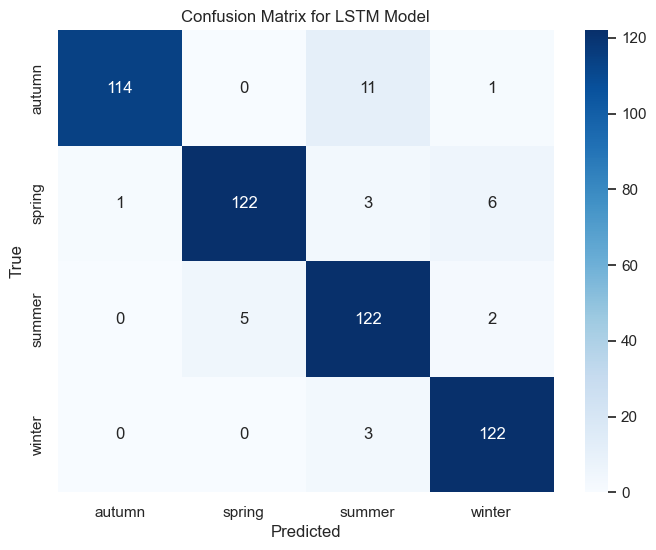

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_valid_np = y_valid.cpu().numpy() if isinstance(y_valid, torch.Tensor) else y_valid
preds_lstm_np = preds_lstm.cpu().numpy() if isinstance(preds_lstm, torch.Tensor) else preds_lstm

cm_lstm = confusion_matrix(y_valid_np, preds_lstm_np)

class_labels = ['autumn', 'spring', 'summer', 'winter']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM Model')
plt.show()


In [48]:
# Define SimpleRNN model
model_RNN = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(128, activation='relu', input_shape=input_shape, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=4, activation='softmax') 
])

model_RNN.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1, 128)         │        19,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,892 (335.52 KB)

 Trainable params: 85,892 (335.52 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_RNN = train_model(model_RNN, dls.train, dls.valid, epochs=50)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.2689 - loss: 12.7113 - val_accuracy: 0.4422 - val_loss: 4.6322
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2835 - loss: 8.3884 - val_accuracy: 0.5083 - val_loss: 1.5900
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3198 - loss: 4.9418 - val_accuracy: 0.5633 - val_loss: 1.3364
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3387 - loss: 3.8135 - val_accuracy: 0.4862 - val_loss: 1.3514
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4055 - loss: 2.5147 - val_accuracy: 0.4807 - val_loss: 1.4935
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4180 - loss: 2.3203 - val_accuracy: 0.4789 - val_loss: 1.0771
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4307 - loss: 1.7756 - val_accuracy: 0.5009 - val_loss: 0.9533
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4599 - loss: 1.6180 - val_accuracy: 0.5009 - val_loss: 0.935

In [50]:
X_valid_rnn, y_valid_rnn = [], []
for x, y in dls.valid:
    X_valid_rnn.append(x.cpu().numpy())  
    y_valid_rnn.append(y.cpu().numpy()) 
X_valid_rnn = np.concatenate(X_valid_rnn)
y_valid_rnn = np.concatenate(y_valid_rnn)

probas_rnn = model_RNN.predict(X_valid_rnn)
preds_rnn = np.argmax(probas_rnn, axis=-1)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [51]:
from sklearn.metrics import classification_report

print("Classification Report for RNN model:")
print(classification_report(y_valid_rnn, preds_rnn))


Classification Report for RNN model:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       136
           1       0.99      0.90      0.94       137
           2       0.81      0.88      0.84       137
           3       0.84      0.95      0.89       135

    accuracy                           0.89       545
   macro avg       0.90      0.89      0.89       545
weighted avg       0.90      0.89      0.89       545



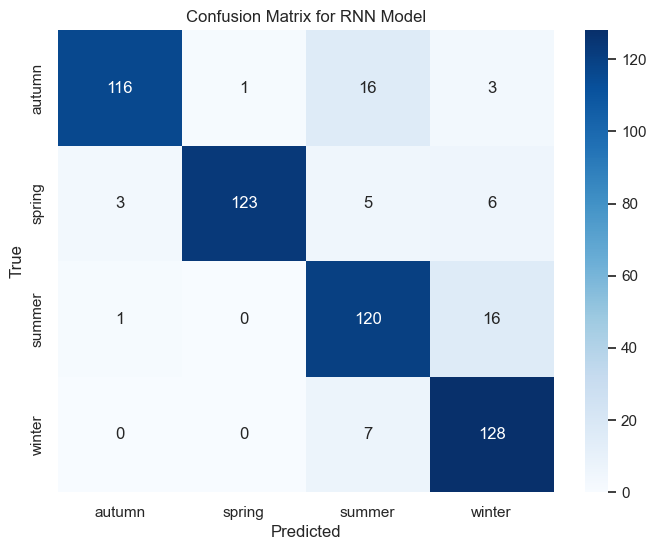

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_rnn = confusion_matrix(y_valid_rnn, preds_rnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, cmap='Blues', fmt='d', xticklabels=['autumn', 'spring', 'summer', 'winter'], yticklabels=['autumn', 'spring', 'summer', 'winter'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RNN Model')
plt.show()


In [53]:
X_valid_rnn, y_valid_rnn = [], []
for x, y in dls.valid:
    X_valid_rnn.append(x.cpu().numpy())  
    y_valid_rnn.append(y.cpu().numpy()) 
X_valid_rnn = np.concatenate(X_valid_rnn)
y_valid_rnn = np.concatenate(y_valid_rnn)

probas_rnn = model_RNN.predict(X_valid_rnn)
preds_rnn = np.argmax(probas_rnn, axis=-1)

probas_lstm = model_LSTM.predict(X_valid_rnn)
preds_lstm = np.argmax(probas_lstm, axis=-1)

accuracy_rnn = accuracy_score(y_valid_rnn, preds_rnn)
result_table_clf.append([model_RNN, round(accuracy_rnn, 3)])

accuracy_lstm = accuracy_score(y_valid_rnn, preds_lstm)
result_table_clf.append([model_LSTM, round(accuracy_lstm, 3)])


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


# Final results comparison


In [55]:
for item in result_table_clf:
    model_name = item[0].__class__.__name__
    model_value = item[1]
    print(f'{model_name}: {model_value}')
    
  #The last two models (Sequential) are RNN AND LSTM

RandomForestClassifier: 0.958
KNeighborsClassifier: 0.98
MUSE: 0.98
ResNet: 0.994
Sequential: 0.894
Sequential: 0.932


-------------------------

-------------------------

## Extracting and preprocessing data for BELGIUM

In [65]:
df_belgium = extract_country(df_raw, country_code='BE', year_min=2015, year_max=2020)
df_belgium

,load_actual_entsoe_transparency,load_forecast_entsoe_transparency,solar_generation_actual,wind_generation_actual,wind_offshore_generation_actual,wind_onshore_generation_actual
utc_timestamp,,,,,,
2015-01-01 00:00:00+00:00,9484.0,9897.0,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,9152.0,9521.0,NaN,734.81,518.66,216.15
2015-01-01 02:00:00+00:00,8799.0,9135.0,NaN,766.64,529.46,237.18
2015-01-01 03:00:00+00:00,8567.0,8909.0,NaN,733.13,406.94,326.19
2015-01-01 04:00:00+00:00,8487.0,8806.0,NaN,730.99,413.49,317.50
...,...,...,...,...,...,...
2020-09-30 19:00:00+00:00,9402.0,9720.0,NaN,1889.72,1497.40,392.32
2020-09-30 20:00:00+00:00,9219.0,9418.0,NaN,2154.67,1688.06,466.61
2020-09-30 21:00:00+00:00,8763.0,8873.0,NaN,2187.48,1715.76,471.72


##### Hourly to Daily (24 hours)

In [66]:

cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}

df_belgium = transform_dataframe(df_belgium, cols_map)
df_belgium.shape

(2100, 3)

In [67]:
df_belgium['Wind+Solar'] = df_belgium[['Wind', 'Solar']].sum(axis=1, skipna=False)
df_belgium.to_csv('belgium.csv')
df_belgium.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01,218.062,NaN,NaN,NaN
2015-01-02,239.467,29.54350,2.11788,31.66138
2015-01-03,244.009,12.69398,0.28626,12.98024
2015-01-04,238.204,5.28131,3.67119,8.95250
2015-01-05,278.853,7.86341,3.16217,11.02558


The cleaned DataFrame **df_belgium** consists of daily electricity usage data for the UK. It includes the following time series data:
*******
- **Date:** Date 
- **Consumption:** Total electricity consumption measured in gigawatt-hours (GWh).
- **Wind:** Consumption of wind energy in gigawatts per hour (GW/h).
- **Solar:** Consumption of solar energy in gigawatts per hour (GW/h).
- **Wind+Solar:** Combined consumption from wind and solar energy sources in gigawatts per hour (GW/h).

# Explore Data

In [68]:
df = pd.read_csv('belgium.csv', parse_dates=['Date'], index_col="Date")
df.sample(5)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2018-09-13,241.358,NaN,9.70656,NaN
2017-05-10,233.717,NaN,19.28908,NaN
2018-12-23,223.509,23.98100,0.48148,24.46248
2020-06-20,191.637,NaN,22.24331,NaN
2018-04-03,240.712,31.45294,9.17368,40.62662


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2015-01-01 to 2020-09-30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  2100 non-null   float64
 1   Wind         1578 non-null   float64
 2   Solar        2098 non-null   float64
 3   Wind+Solar   1578 non-null   float64
dtypes: float64(4)
memory usage: 82.0 KB


In [70]:
df.shape

(2100, 4)

In [71]:
df.describe()

,Consumption,Wind,Solar,Wind+Solar
count,2100.000000,1578.000000,2098.000000,1578.000000
mean,235.401214,21.228825,9.442956,29.754300
std,24.620844,14.356904,6.464704,14.360823
min,173.726000,0.849135,0.098220,2.305115
25%,217.520750,9.636826,3.540755,20.080250
50%,236.230000,17.845695,8.833360,27.273865
75%,251.697250,29.414903,14.366885,37.544213
max,296.117000,71.346070,28.238740,90.006770


## Data cleaning

In [72]:
df.isna().sum()

Consumption      0
Wind           522
Solar            2
Wind+Solar     522
dtype: int64

In [73]:
df.fillna(method='ffill', axis=0, inplace=True)

# Time series classification

- Divide the dataset into four seasons: winter, spring, autumn, and summer.
- Each data point is the consumption recorded in 1-hour intervals.therefore:
  - Define sections of 24 hours (1 day).
  - Each part makes up 24 data points representing hourly consumption.

In [74]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    # Exclude IF OUT OF RANGE
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
    return df_out

def transform_dataframe(df, cols_map):
    df = df[list(cols_map.keys())].rename(columns=cols_map)    
    df = df / 1000 # Convert from MW to GW
    df = df.rename_axis('Date')
    return df

def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

## Data

In [75]:
df_all = pd.read_csv('time_series_60min_singleindex.csv', index_col='utc_timestamp', parse_dates=True, low_memory=False)

df_hrly = extract_country(df_all, country_code='BE', year_min=2015, year_max=2020)

df_hrly.sample(3)

cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df = transform_dataframe(df_hrly, cols_map).dropna()

df['Wind+Solar'] = df[['Wind', 'Solar']].sum(axis=1, skipna=False)
df.to_csv('be_clf_data.csv')
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01 08:00:00+00:00,8.340,1.14620,0.09266,1.23886
2015-01-01 09:00:00+00:00,8.677,1.13566,0.37489,1.51055
2015-01-01 10:00:00+00:00,8.899,1.06567,0.73992,1.80559
2015-01-01 11:00:00+00:00,9.092,1.02083,0.93806,1.95889
2015-01-01 12:00:00+00:00,9.088,1.09639,0.84865,1.94504


In [76]:
df.isna().sum()

Consumption    0
Wind           0
Solar          0
Wind+Solar     0
dtype: int64

### Splitting into seasons

In [77]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(490, 24) (482, 24) (455, 24) (504, 24)


### Seasons visualization

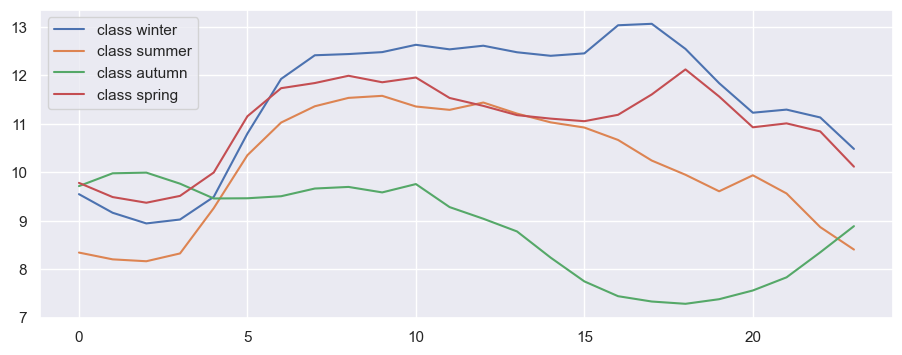

In [78]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

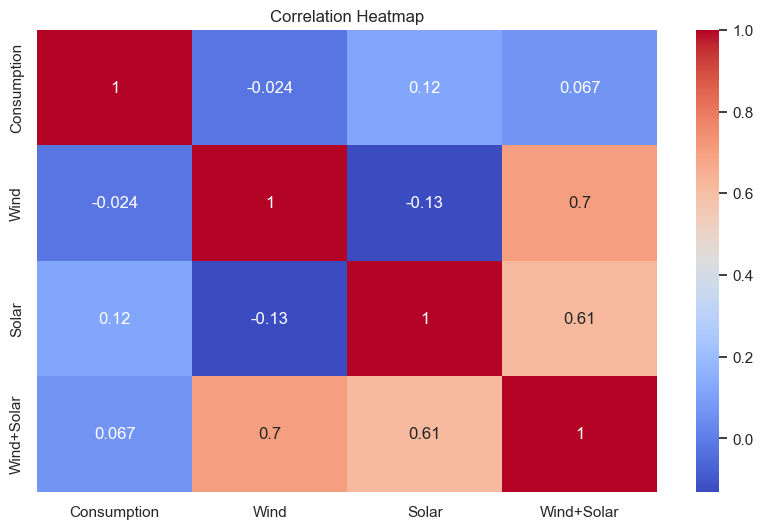

In [79]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


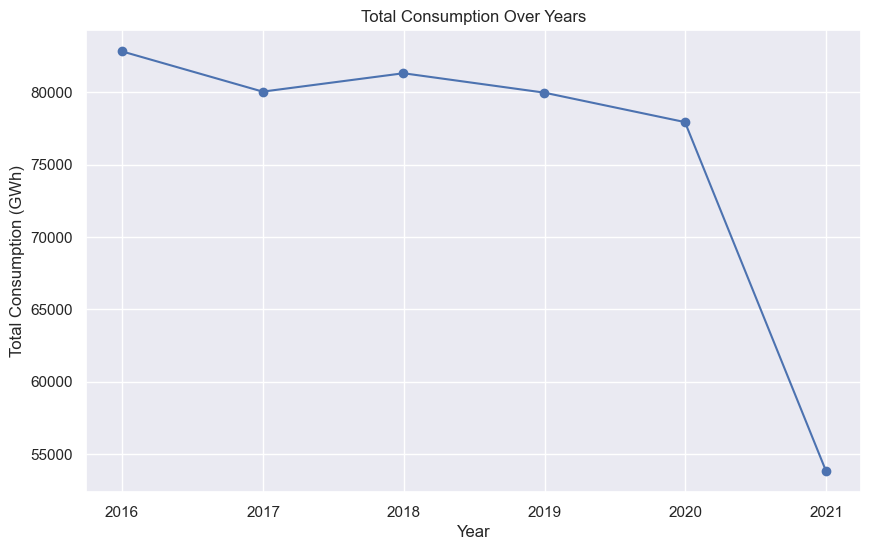

In [80]:
df_yearly = df.resample('Y').sum()
plt.figure(figsize=(10, 6))
plt.plot(df_yearly.index, df_yearly['Consumption'], marker='o')
plt.title('Total Consumption Over Years')
plt.xlabel('Year')
plt.ylabel('Total Consumption (GWh)')
plt.grid(True)
plt.show()


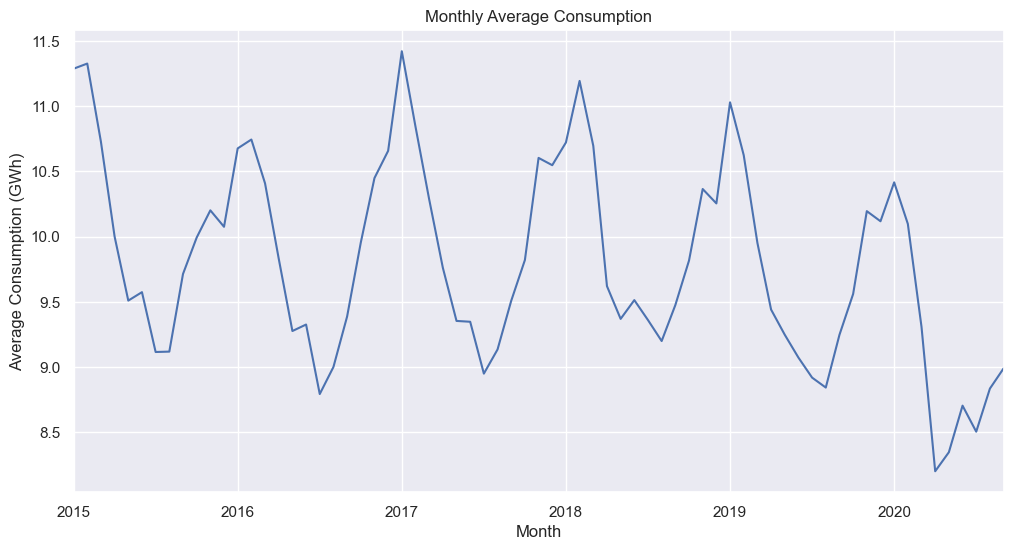

In [81]:
df_monthly = df.resample('M').mean()
plt.figure(figsize=(12, 6))
df_monthly['Consumption'].plot()
plt.title('Monthly Average Consumption')
plt.xlabel('Month')
plt.ylabel('Average Consumption (GWh)')
plt.grid(True)
plt.show()

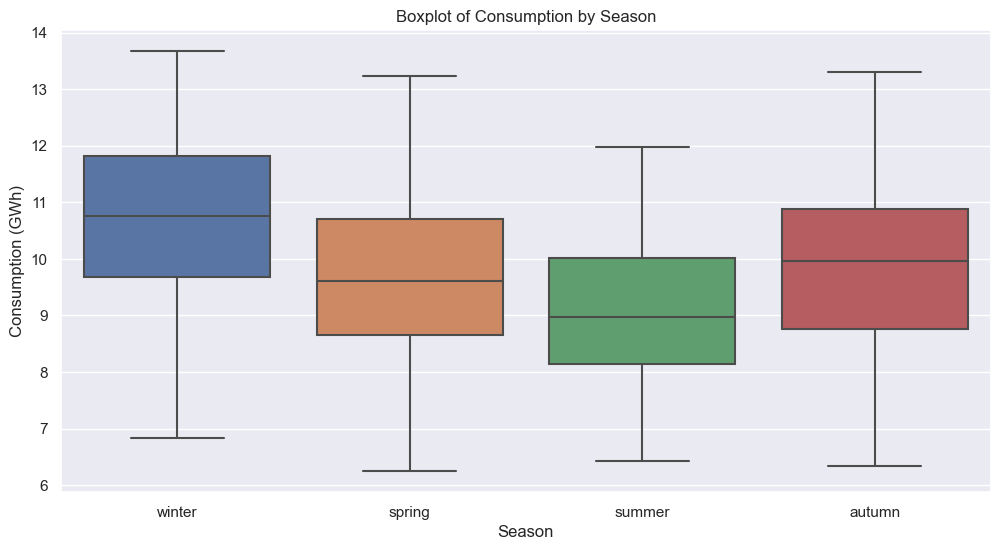

In [82]:

df['month'] = df.index.month
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}

df['season'] = df['month'].apply(lambda x: 'winter' if x in seasons['winter'] else 
                                  'spring' if x in seasons['spring'] else 
                                  'summer' if x in seasons['summer'] else 
                                  'autumn')

plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='Consumption', data=df)
plt.title('Boxplot of Consumption by Season')
plt.xlabel('Season')
plt.ylabel('Consumption (GWh)')
plt.show()


## Preprocessing

In [83]:
X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1351, 24) (1351,) (580, 24) (580,)


In [84]:
result_table_clf = []

## RandomForestClassifier


In [85]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

result_table_clf.append([clf, round(clf.score(X_test, y_test), 3)])

 test score 0.641


## KNeighborsClassifier


In [86]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}') 

result_table_clf.append([clf, round(clf.score(X_test, y_test), 3)])

 test score 0.641


## KNeighborsTimeSeriesClassifier



In [87]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

result_table_clf.append([clf, round(clf.score(X_test, y_test), 3)])

 test score 0.705


## MUSE (MUltivariate Symbolic Extension)


In [88]:
from sktime.classification.dictionary_based import MUSE    
clf = MUSE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

print(f' test score {clf.score(X_test, y_test):.3f}')

result_table_clf.append([clf, round(clf.score(X_test, y_test), 3)])

 test score 0.788


## Methods comparison

In [89]:
for item in result_table_clf:
    model_name = item[0].__class__.__name__
    model_value = item[1]
    print(f'{model_name}: {model_value}')

RandomForestClassifier: 0.641
KNeighborsClassifier: 0.641
KNeighborsTimeSeriesClassifier: 0.705
MUSE: 0.788


# Time Series Classification with Deep Learning

In [90]:
from tsai.all import *
import warnings

computer_setup()

os              : macOS-14.4.1-arm64-arm-64bit
python          : 3.10.9
tsai            : 0.3.9
fastai          : 2.7.15
fastcore        : 1.5.29
torch           : 2.1.0
device          : mps
cpu cores       : 8
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A


## Data

In [91]:
X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    1*np.ones(winter.shape[0]),
                    2*np.ones(summer.shape[0]),
                    3*np.ones(autumn.shape[0]),
                    4*np.ones(spring.shape[0])
                   ))


X = np.atleast_3d(X).transpose(0,2,1)
y.astype(int)

array([1, 1, 1, ..., 4, 4, 4])

In [92]:

class_map = {
    1:'winter',   
    2:'summer',   
    3:'autumn',   
    4:'spring',   
    }
class_map

labeler = ReLabeler(class_map)
y = labeler(y) 

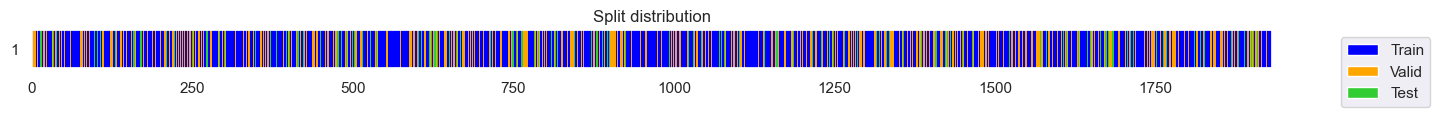

In [93]:
## split into train and test and validation 
splits = get_splits(y, 
                    n_splits=1, 
                    valid_size=0.3, 
                    test_size=0.1, 
                    shuffle=True, 
                    balance=False, 
                    stratify=True,
                    random_state=42, 
                    show_plot=True, 
                    verbose=True)


In [94]:
## dataset and loaders

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
 
bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

## ResNet
Try pretrained Resnet and choose optimal learning rate to try find better accuracy

In [95]:
arch = ResNet
k = {}
model = create_model(arch, dls=dls, **k)
model = build_ts_model(ResNet, arch_config=k, dls=dls)

### Optimal learning rate

SuggestedLRs(valley=0.0014454397605732083)

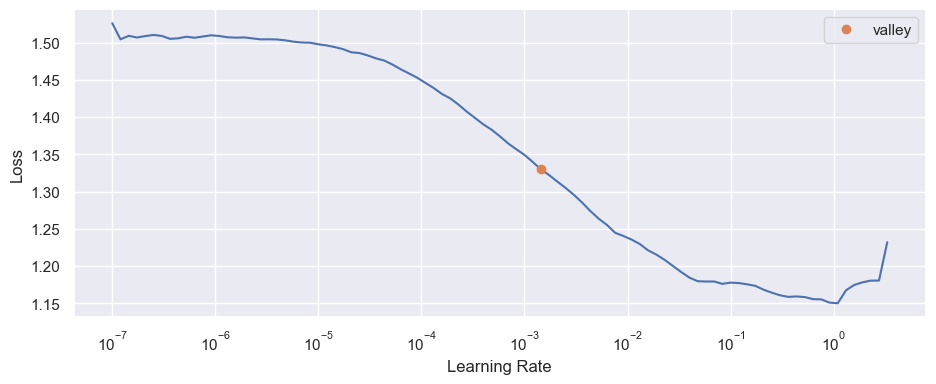

In [96]:
learn = ts_learner(dls, arch=model, metrics=accuracy) 
learn.lr_find()

In [97]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 200, lr_max =0.0014)

epoch,train_loss,valid_loss,accuracy,time
0,1.444614,1.823464,0.253886,00:00
1,1.382833,1.821519,0.253886,00:00
2,1.337772,1.709486,0.255613,00:00
3,1.301709,1.556958,0.286701,00:00
4,1.271106,1.417151,0.360967,00:00
5,1.248631,1.291484,0.414508,00:00
6,1.227723,1.195482,0.450777,00:00
7,1.209371,1.126033,0.481865,00:00
8,1.190553,1.086914,0.521589,00:00
9,1.170965,1.068432,0.535406,00:00


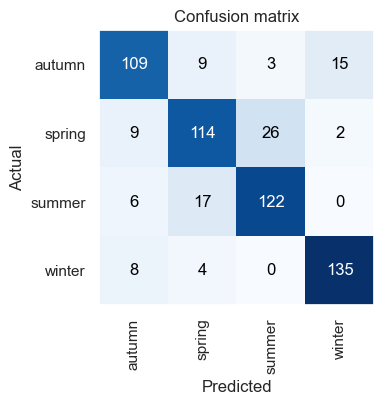

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [99]:
probas, _, preds = learn.get_X_preds(X[splits[2]])

class_map = {
    'winter':3,   
    'summer':2,   
    'autumn':0,   
    'spring':1,  
    }
class_map

labeler = ReLabeler(class_map)
labeler

<function tsai.data.preprocessing.ReLabeler.<locals>._relabel(y)>

In [100]:
model_score = accuracy_score(np.argmax(probas,axis=-1), labeler(y[splits[2]]))
print(f' test score {model_score}')
result_table_clf.append([model, round(model_score, 3)])

 test score 0.8341968911917098


## LSTM and RNN Models 

In [101]:
import tensorflow as tf

In [102]:
def train_model(model, train_dl, valid_dl, epochs=50, batch_size=256):
    X_train, y_train = [], []
    for x, y in train_dl:
        X_train.append(x.cpu().numpy())  
        y_train.append(y.cpu().numpy())  
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    X_valid, y_valid = [], []
    for x, y in valid_dl:
        X_valid.append(x.cpu().numpy())  
        y_valid.append(y.cpu().numpy()) 
    X_valid = np.concatenate(X_valid)
    y_valid = np.concatenate(y_valid)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    return history


In [103]:
input_shape = X.shape[-2:]

model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=4, activation='softmax') 
])

model_LSTM.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 128)         │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,020 (1.30 MB)

 Trainable params: 342,020 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_LSTM = train_model(model_LSTM, dls.train, dls.valid, epochs=50)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.2645 - loss: 1.3859 - val_accuracy: 0.2608 - val_loss: 1.3845
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2611 - loss: 1.3840 - val_accuracy: 0.3506 - val_loss: 1.3814
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2865 - loss: 1.3815 - val_accuracy: 0.2539 - val_loss: 1.3762
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2655 - loss: 1.3784 - val_accuracy: 0.2573 - val_loss: 1.3676
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2661 - loss: 1.3707 - val_accuracy: 0.2763 - val_loss: 1.3563
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3020 - loss: 1.3629 - val_accuracy: 0.3610 - val_loss: 1.3413
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3379 - loss: 1.3438 - val_accuracy: 0.4145 - val_loss: 1.3120
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3169 - loss: 1.3324 - val_accuracy: 0.4180 - val_loss: 1.2643

In [105]:

for X_valid, y_valid in dls.valid:
    break  
X_valid_cpu = X_valid.cpu()

probas_lstm = model_LSTM.predict(X_valid_cpu)
preds_lstm = np.argmax(probas_lstm, axis=-1)



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [106]:
from sklearn.metrics import classification_report
print("Classification Report for LSTM model:")
print(classification_report(y_valid.cpu().numpy(), preds_lstm))


Classification Report for LSTM model:
              precision    recall  f1-score   support

           0       0.52      0.29      0.37       119
           1       0.42      0.20      0.27       133
           2       0.45      0.79      0.57       128
           3       0.60      0.73      0.66       132

    accuracy                           0.50       512
   macro avg       0.50      0.50      0.47       512
weighted avg       0.50      0.50      0.47       512



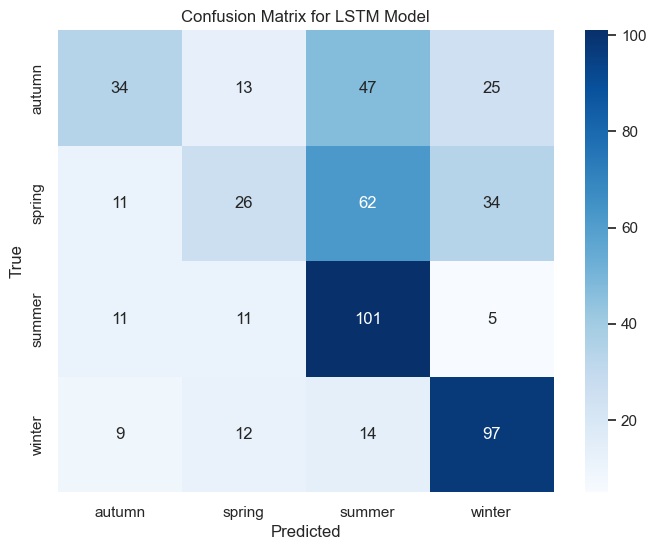

In [107]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_valid_np = y_valid.cpu().numpy() if isinstance(y_valid, torch.Tensor) else y_valid
preds_lstm_np = preds_lstm.cpu().numpy() if isinstance(preds_lstm, torch.Tensor) else preds_lstm

cm_lstm = confusion_matrix(y_valid_np, preds_lstm_np)

class_labels = ['autumn', 'spring', 'summer', 'winter']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM Model')
plt.show()


In [108]:
model_RNN = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(128, activation='relu', input_shape=input_shape, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=4, activation='softmax') 
])

model_RNN.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 1, 128)         │        19,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,892 (335.52 KB)

 Trainable params: 85,892 (335.52 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
model_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_RNN = train_model(model_RNN, dls.train, dls.valid, epochs=50)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.2418 - loss: 3.6188 - val_accuracy: 0.2608 - val_loss: 2.0146
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2620 - loss: 2.6782 - val_accuracy: 0.2211 - val_loss: 1.4162
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2615 - loss: 1.8887 - val_accuracy: 0.2366 - val_loss: 1.5107
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2465 - loss: 1.7774 - val_accuracy: 0.2746 - val_loss: 1.3867
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2514 - loss: 1.6080 - val_accuracy: 0.2608 - val_loss: 1.4143
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2583 - loss: 1.4992 - val_accuracy: 0.2608 - val_loss: 1.4360
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2462 - loss: 1.4943 - val_accuracy: 0.2625 - val_loss: 1.4055
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2876 - loss: 1.4358 - val_accuracy: 0.2798 - val_loss: 1.3868

In [110]:
X_valid_rnn, y_valid_rnn = [], []
for x, y in dls.valid:
    X_valid_rnn.append(x.cpu().numpy())  
    y_valid_rnn.append(y.cpu().numpy()) 
X_valid_rnn = np.concatenate(X_valid_rnn)
y_valid_rnn = np.concatenate(y_valid_rnn)

probas_rnn = model_RNN.predict(X_valid_rnn)
preds_rnn = np.argmax(probas_rnn, axis=-1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [111]:
from sklearn.metrics import classification_report

print("Classification Report for RNN model:")
print(classification_report(y_valid_rnn, preds_rnn))


Classification Report for RNN model:
              precision    recall  f1-score   support

           0       0.40      0.43      0.42       136
           1       0.31      0.21      0.25       151
           2       0.22      0.07      0.11       145
           3       0.31      0.61      0.41       147

    accuracy                           0.33       579
   macro avg       0.31      0.33      0.29       579
weighted avg       0.31      0.33      0.29       579



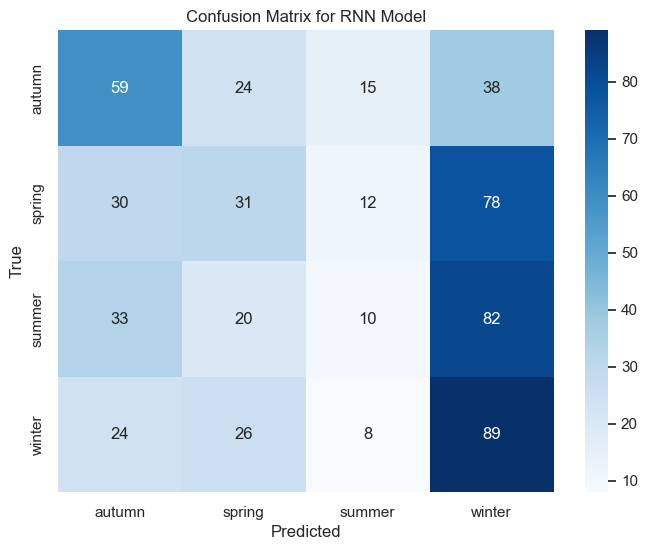

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_rnn = confusion_matrix(y_valid_rnn, preds_rnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, cmap='Blues', fmt='d', xticklabels=['autumn', 'spring', 'summer', 'winter'], yticklabels=['autumn', 'spring', 'summer', 'winter'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RNN Model')
plt.show()


In [113]:
X_valid_rnn, y_valid_rnn = [], []
for x, y in dls.valid:
    X_valid_rnn.append(x.cpu().numpy())  
    y_valid_rnn.append(y.cpu().numpy()) 
X_valid_rnn = np.concatenate(X_valid_rnn)
y_valid_rnn = np.concatenate(y_valid_rnn)

probas_rnn = model_RNN.predict(X_valid_rnn)
preds_rnn = np.argmax(probas_rnn, axis=-1)

probas_lstm = model_LSTM.predict(X_valid_rnn)
preds_lstm = np.argmax(probas_lstm, axis=-1)

accuracy_rnn = accuracy_score(y_valid_rnn, preds_rnn)
result_table_clf.append([model_RNN, round(accuracy_rnn, 3)])

accuracy_lstm = accuracy_score(y_valid_rnn, preds_lstm)
result_table_clf.append([model_LSTM, round(accuracy_lstm, 3)])


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


# Final results comparison


In [114]:
for item in result_table_clf:
    model_name = item[0].__class__.__name__
    model_value = item[1]
    print(f'{model_name}: {model_value}')
    
    #The last two models (Sequential) are RNN AND LSTM

RandomForestClassifier: 0.641
KNeighborsClassifier: 0.641
KNeighborsTimeSeriesClassifier: 0.705
MUSE: 0.788
ResNet: 0.834
Sequential: 0.326
Sequential: 0.506
